# Exercise 1

## Imports

In [5]:
import json
import pickle
import os.path
import pyspark.sql.functions as F
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StringType, ArrayType, FloatType, DoubleType, IntegerType, StructField, StructType
from itertools import combinations
from typing import Iterable, Any, List, Set

import pandas as pd
import numpy as np
from typing import Union

import matplotlib.pyplot as plt

## Spark initialization

In [6]:
spark = SparkSession.builder \
    .appName('exercise1') \
    .config('spark.master', 'local[*]') \
    .getOrCreate()

## Prepare the data

In [7]:
tracks_df = (spark.read
    .option("multiline", "true")
    .option("quote", '"')
    .option("escape", '"')
    .csv('data/tracks.csv')
)

# rename columns with row values from first row to second row
column_categories = list(zip(*tracks_df.take(2)))
columns = tracks_df.columns
tracks_df = tracks_df.select(F.col(columns[0]).alias('track_id'),
    *(F.col(column).alias("-".join(map(str, categories)))
    for column, categories in zip(columns[1:], column_categories[1:]))
)

tracks_df = (tracks_df
    .filter(F.col("track_id").isNotNull()) 
    .filter(F.col("track_id") != "track_id")
)

tracks_df.show()

+--------+--------------+-------------------+-------------------+--------------+---------------+--------+--------------------+-------------+--------------------+----------+--------------------+------------+----------------+------------------------+----------------------+------------------------+--------------------+---------------+-------------------+----------------+---------+---------------+------------------+----------------+--------------------+--------------------+-----------------------+--------------------+--------------------+---------------------+---------+----------+--------------+--------------+--------------+-------------------+-------------------+--------------+---------------+---------------+------------+-----------------+--------------------+--------------+-------------------+--------------------+-------------+--------------+------------+---------------+----------+--------------------+
|track_id|album-comments| album-date_created|album-date_released|album-engineer|album-

In [8]:
features_df = (spark.read
    .csv('data/features.csv')
)

# rename columns with row values from first row to second row
column_categories = list(zip(*features_df.take(3)))
columns = features_df.columns
features_df = features_df.select(F.col(columns[0]).alias('track_id'),
    *(F.col(column).cast(DoubleType()).alias("-".join(map(str, categories)))
    for column, categories in zip(columns[1:], column_categories[1:]))
)

features_df = (features_df
    .filter(F.col("track_id") != "feature")
    .filter(F.col("track_id") != "statistics")
    .filter(F.col("track_id") != "number")
    .filter(F.col("track_id") != "track_id")
)

features_music_columns = features_df.columns.copy()
features_music_columns.remove('track_id')

## Agglomerative clustering (in-memory)

In [9]:
dataset_subset_name = "small"

small_tracks_df = tracks_df.filter(F.col("set-subset") == dataset_subset_name)
small_features_df = (features_df
    .join(small_tracks_df, "track_id", "left")
    .filter(F.col("set-subset").isNotNull())
    .select(features_df.columns)
)

small_features_pd = small_features_df.toPandas()

In [10]:
def calculate_metrics(pd_df, centroids):
    """Calculate the metrics (radius, diameter, density_r, density_d) for each cluster"""

    cluster = pd_df["cluster"].values[0]
    metrics = pd.DataFrame({'radius': [0], 'diameter': [0],'density_r': [0],'density_d': [0]}, columns=['radius', 'diameter','density_r','density_d'])
    centroid = centroids[cluster].reshape(1,-1)

    matrix = pd_df.drop(columns=["cluster", "track_id"]).to_numpy()
    
    matrix_radius = np.sqrt(np.sum((matrix - centroid)**2, axis=1))
    metrics.loc[0,'radius'] = np.max(matrix_radius)
    # calculate density with radius
    metrics.loc[0,'density_r'] = len(pd_df) / metrics.loc[0,'radius']**2

    for i in range(matrix.shape[0]):
        matrix_diameter = np.sqrt(np.sum((matrix[i:,:] - matrix[i,:])**2, axis=1))

        max_diameter = np.max(matrix_diameter)
        if max_diameter > metrics.loc[0,'diameter']:
            metrics.loc[0,'diameter'] = max_diameter
        
    # calculate density with diameter
    metrics.loc[0,'density_d'] = len(pd_df) / metrics.loc[0,'diameter']**2

    return metrics

In [11]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
import numpy.typing as npt

n_clusters_range = range(8, 17)

metrics_pd_array = []

small_features_pd = pd.concat(objs=[small_features_pd, pd.DataFrame(data=np.zeros((len(small_features_pd), 1), dtype=np.int32), columns=["cluster"])], axis=1)

def cluster_agglomeratively(data: pd.DataFrame, n_clusters: int) -> npt.NDArray[np.float32]:
    if "cluster" not in data.columns:
        raise ValueError("The 'cluster' column should be present in the dataframe!")
    
    data_features_only = data.drop(columns=["cluster", "track_id"])

    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    clusterer.fit(data_features_only)
    
    centroid_calculator = NearestCentroid()
    centroid_calculator.fit(data_features_only, clusterer.labels_)

    data["cluster"] = clusterer.labels_
    return centroid_calculator.centroids_

if os.path.exists("./results/metrics_pd_array_pickle.pkl"):
    with open("./results/metrics_pd_array_pickle.pkl",'rb') as f:
        metrics_pd_array = pickle.load(f)

else:
    # i = 8 until 16
    for n_clusters in n_clusters_range:
        print(f"n_clusters: {n_clusters}")
        centroids = cluster_agglomeratively(small_features_pd, n_clusters)
        metrics_pd_array.append(small_features_pd.groupby("cluster").apply(calculate_metrics, centroids))

    # TODO: weird column at 0s without name??
    with open("./results/metrics_pd_array_pickle.pkl",'wb') as f:
        pickle.dump(metrics_pd_array, f)

### Clustering analysis

To compare the different number of clusters $k$, we printed the average and variance of each of the calculated density metrics, since it's those we are concerned with when assessing the quality of the clustering.

More specifically, we are looking for high values for the average density and low values for the average variance.

In [12]:
for i in metrics_pd_array:
    density_r_average = i["density_r"].mean()
    density_d_average = i["density_d"].mean()
    density_r_variance = i["density_r"].var()
    density_d_variance = i["density_d"].var()

    print(f"Average density_r: {density_r_average}, Average density_d: {density_d_average}, Variance density_r: {density_r_variance}, Variance density_d: {density_d_variance}")
    print("\n")

Average density_r: 7.962110575648213e-05, Average density_d: 3.599342497079214e-05, Variance density_r: 7.554281742039276e-09, Variance density_d: 1.632545349816937e-09


Average density_r: 8.46827574451412e-05, Average density_d: 3.664885346147574e-05, Variance density_r: 7.747059677670204e-09, Variance density_d: 1.6211171070541367e-09


Average density_r: 8.164132830338627e-05, Average density_d: 3.4647549186503005e-05, Variance density_r: 7.052526954162877e-09, Variance density_d: 1.4927145547250588e-09


Average density_r: 7.530009483773654e-05, Average density_d: 3.330844689045004e-05, Variance density_r: 5.65147072510877e-09, Variance density_d: 1.2235780221208591e-09


Average density_r: 7.0833141687739e-05, Average density_d: 3.124377322263076e-05, Variance density_r: 5.389143411471879e-09, Variance density_d: 1.1658465305734218e-09


Average density_r: 6.755260440629955e-05, Average density_d: 2.980317784207617e-05, Variance density_r: 5.035928633263812e-09, Variance density_

We also plotted these averages on a heatmap plot for easier visualization.

In [13]:
metrics_heatmap = np.array([
    [
        m["density_r"].mean(),
        m["density_d"].mean(),
        m["density_r"].var(),
        m["density_d"].var(),
    ]
    for m in metrics_pd_array
])

metrics_heatmap_standardized = (metrics_heatmap - metrics_heatmap.mean(axis=0)) / metrics_heatmap.std(axis=0)

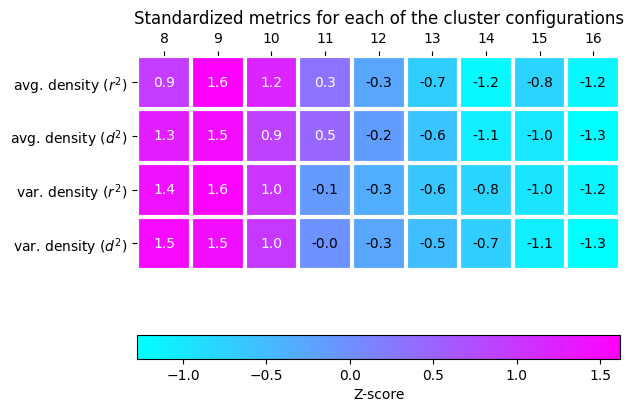

In [14]:
from plot_helpers import heatmap, annotate_heatmap

fig, ax = plt.subplots()

im, cbar = heatmap(
    data=metrics_heatmap_standardized.T,
    row_labels=["avg. density ($r^2$)", "avg. density ($d^2$)", "var. density ($r^2$)", "var. density ($d^2$)"],
    col_labels=list(map(str, n_clusters_range)),
    cbarlabel="Z-score",
    cbar_kw={"location": "bottom"},
    cmap="cool",
    ax=ax)
texts = annotate_heatmap(im, valfmt="{x:.1f}")

ax.set_title("Standardized metrics for each of the cluster configurations")

fig.tight_layout()

*Será que k=11 não deve ser melhor?*

From these results, we decided to choose $k=9$ since it provided by far the greatest values for the average density.
Although it also provided a lot of variance, we notice this trend of high/low average density being related with high/low average variance for the other configurations as well.

## BFR Algorithm

In [15]:
# TODO: results can be: density of clusters, number of nodes in each cluster, etc., but not strictly necessary

### Parameters

In [16]:
from sklearn.cluster import DBSCAN

n_clusters = 9

max_memory_used_bytes = int(.1e9)
# Assumes all columns are doubles/longs, therefore 8 bytes
rows_per_iteration = max_memory_used_bytes // (8 * len(features_df.columns))

seed_random = 0

# Threshold in terms of standard deviations away from centroid, in each dimension
cluster_distance_threshold_standard_deviations = 1
cluster_distance_threshold = ((cluster_distance_threshold_standard_deviations**2) * len(features_music_columns)) ** 0.5

# TODO: choose threshold and justify decision
compression_set_merge_variance_threshold = 1.001

# TODO: choose threshold and justify decision
#? distance threshold for inserting point in a compressed set???
dbscan_eps = 1000

### Initialize clusters

In [17]:
centroids = cluster_agglomeratively(small_features_pd, n_clusters)

### Loop

In [18]:
import dataclasses

@dataclasses.dataclass(init=False)
class SummarizedCluster:
    n:      int                     
    sum_:   npt.NDArray[np.float64]
    sumsq_: npt.NDArray[np.float64]
    id_:    Union[int, None]
    tracks: Set[int]

    def __init__(self, dimensions: int, id_: int=None):
        self.n = 0
        self.sum_ = np.zeros((dimensions,), dtype=np.float64)
        self.sumsq_ = np.zeros((dimensions,), dtype=np.float64)
        self.id_ = id_
        self.tracks = set()
    
    def summarize(self, point: npt.NDArray[np.float64], track_id: int):
        self.n += 1
        self.sum_ += point
        self.sumsq_ += point**2
        self.tracks.add(track_id)
    
    def summarize_points(self, points: npt.NDArray[np.float64], track_ids: Set[int]):
        self.n += points.shape[0]
        self.sum_ += np.sum(points, axis=0)
        self.sumsq_ += np.sum(points**2, axis=0)
        self.tracks |= track_ids

    def centroid(self) -> npt.NDArray[np.float64]:
        return self.sum_ / self.n

    def variance(self) -> npt.NDArray[np.float64]:
        return (self.sumsq_ / self.n) - (self.sum_ / self.n)**2

    def standard_deviation(self) -> npt.NDArray[np.float64]:
        return np.sqrt(self.variance())

    def __add__(self, other: 'SummarizedCluster') -> 'SummarizedCluster':
        if not isinstance(other, SummarizedCluster):
            raise ValueError(f"Addition is not supported between a SummarizedCluster and a '{type(other)}'.")
        if self.id_ is not None and other.id_ is not None and self.id_ != self.other:
            raise ValueError(f"Clusters {self} and {other} have different explicit ids ({self.id_} != {other.id_}).")
        if self.tracks & other.tracks:
            raise ValueError(f"The clusters {self} and {other} overlap each other.")
        res = SummarizedCluster(self.sum_.size, self.id_ if self.id_ is not None else other.id_)
        res.n = self.n + other.n
        res.sum_ = self.sum_ + other.sum_
        res.sumsq_ = self.sumsq_ + other.sumsq_
        res.tracks = self.tracks | other.tracks
        return res

    def __iadd__(self, other: 'SummarizedCluster') -> 'SummarizedCluster':
        if not isinstance(other, SummarizedCluster):
            raise ValueError(f"Addition is not supported between a SummarizedCluster and a '{type(other)}'.")
        if self.id_ is not None and other.id_ is not None and self.id_ != self.other:
            raise ValueError(f"Clusters {self} and {other} have different explicit ids ({self.id_} != {other.id_}).")
        if self.tracks & other.tracks:
            raise ValueError(f"The clusters {self} and {other} overlap each other.")
        self.id_ = self.id_ if self.id_ is not None else other.id_
        self.n = self.n + other.n
        self.sum_ = self.sum_ + other.sum_
        self.sumsq_ = self.sumsq_ + other.sumsq_
        self.tracks = self.tracks | other.tracks
        return self

    def __str__(self) -> str:
        return f'SummarizedCluster({self.id_}, n={self.n})'

    def __repr__(self) -> str:
        return str(self)

In [19]:
discard_sets: List[SummarizedCluster] = [SummarizedCluster(len(features_music_columns), id_) for id_ in range(n_clusters)]
compression_sets: List[SummarizedCluster] = []
retained_set: pd.DataFrame = pd.DataFrame(data=[], columns=features_df.columns)

Summarize clusters with the clustering of the small dataset subset.

In [20]:
def summarize_cluster_df(cluster_df: pd.DataFrame) -> None:
    cluster_id = cluster_df["cluster"].values[0]
    cluster_features_mtx = cluster_df.drop(columns=["cluster", "track_id"]).to_numpy()
    
    track_ids = set(cluster_df["track_id"].values)

    discard_set = discard_sets[cluster_id]
    discard_set.summarize_points(cluster_features_mtx, track_ids)

small_features_pd.groupby("cluster").apply(summarize_cluster_df)

""


Setup functions

In [21]:
assert len(centroids) == n_clusters, "The number of clusters does not coincide with the number of random centroids!"

def mahalanobis_distance_pd(x: pd.DataFrame, s: SummarizedCluster) -> pd.Series:
    return (((x - s.centroid()) / s.standard_deviation())**2).sum(axis=1) ** 0.5

In [22]:
features_without_small_df = (features_df
    .join(small_tracks_df, "track_id", "left")
    .filter(F.col("set-subset").isNull())
    .select(features_df.columns)
)

total_rows = features_without_small_df.count()
split_weights = [1.0] * (1 + (total_rows // rows_per_iteration))

# Non-overlapping, manually tested
split_dfs = features_without_small_df.randomSplit(split_weights, seed=seed_random)

Assign discard set id to each point in a set of loaded points

In [23]:
def assign_discard_sets(loaded_points_pd: pd.DataFrame):
    prefix = "cluster_distance_"
    cluster_distance_columns = [f"{prefix}{i}" for i in range(n_clusters)]

    loaded_points_pd = pd.concat(
        objs=[loaded_points_pd, pd.DataFrame(
            data=np.zeros((loaded_points_pd.shape[0], len(cluster_distance_columns) + 2)),
            columns=cluster_distance_columns + ['min_cluster_distance', 'cluster_id'])],
        axis=1
    )

    for i, discard_set in enumerate(discard_sets):
        loaded_points_pd[f"cluster_distance_{i}"] = mahalanobis_distance_pd(loaded_points_pd.iloc[:, 1:519], discard_set)
    loaded_points_pd["min_cluster_distance"] = loaded_points_pd[cluster_distance_columns].min(axis=1)
    loaded_points_pd["cluster_id"] = loaded_points_pd[cluster_distance_columns].idxmin(axis=1).str.slice(start=len(prefix)).astype(np.int32)

    loaded_points_pd.drop(columns=cluster_distance_columns, inplace=True)

    # Don't consider the points that surpass the threshold for the discard sets
    loaded_points_pd.loc[loaded_points_pd["min_cluster_distance"] >= cluster_distance_threshold, "cluster_id"] = -1
    loaded_points_pd.drop(columns=["min_cluster_distance"], inplace=True)

    return loaded_points_pd

In [24]:
def print_progress(progress: float, message: str):
    print(f"[{progress:2%}] {message:100}", end="\r")

print_progress(0, "Initialized BFR")

for split_idx, loaded_points_df in enumerate(split_dfs):
    progress = split_idx / len(split_weights)
    
    print_progress(progress, "Collecting split into memory...")
    loaded_points_pd = loaded_points_df.toPandas()

    print_progress(progress, "Clustering with the Mahalanobis distance...")  
    loaded_points_pd = assign_discard_sets(loaded_points_pd)
    
    print_progress(progress, "Calculated and collected Mahalanobis distances")

    for cluster_id, cluster_pd in loaded_points_pd.groupby("cluster_id"):
        track_ids = cluster_pd["track_id"]
        features_list = cluster_pd[features_music_columns]

        print_progress(progress, f"Evaluating cluster {cluster_id}...")

        # Step 3 - check which points go to the discard sets
        if cluster_id != -1:
            discard_set = discard_sets[cluster_id]
            discard_set.summarize_points(features_list, set(track_ids))
        
        # Step 4 - check which points go to the compression sets or the retained set
        else:
            cluster_with_retained_pd = pd.concat(objs=[cluster_pd, retained_set], axis=0)

            # Use same distance as above
            clusterer = DBSCAN(eps=dbscan_eps, metric='euclidean')
            clusterer.fit(cluster_with_retained_pd[features_music_columns])

            retained_set = cluster_with_retained_pd[clusterer.labels_ == -1]

            mini_clusters = set(clusterer.labels_) - {-1}

            # Create compression sets
            compression_sets_temp = [SummarizedCluster(len(features_music_columns), None) for _ in mini_clusters]
            for mini_cluster_id in mini_clusters:
                compression_sets_temp[mini_cluster_id].summarize_points(
                    cluster_with_retained_pd[features_music_columns][clusterer.labels_ == mini_cluster_id], 
                    set(cluster_with_retained_pd['track_id'][clusterer.labels_ == mini_cluster_id])
                )
            
            compression_sets.extend(compression_sets_temp)
        
    print_progress(progress, f"Finished evaluating clusters (compression sets: {len(compression_sets)}, retained set: {len(retained_set)})")

    # Step 5 - merge compression sets
    compressing = True
    while compressing:
        compressing = False
        merged_compression_sets = []
        compression_set_idxs_to_remove = set()

        for (idx_1, compression_set_1), (idx_2, compression_set_2) in combinations(enumerate(compression_sets), 2):
            if idx_1 in compression_set_idxs_to_remove or idx_2 in compression_set_idxs_to_remove:
                continue

            merged_compression_set = compression_set_1 + compression_set_2
            if merged_compression_set.variance().mean() < compression_set_merge_variance_threshold * max(compression_set_1.variance().mean(), compression_set_2.variance().mean()):
                merged_compression_sets.append(merged_compression_set)
                compression_set_idxs_to_remove.add(idx_1)
                compression_set_idxs_to_remove.add(idx_2)
                compressing = True
        
        compression_sets: List[SummarizedCluster] = [cs for i, cs in enumerate(compression_sets) if i not in compression_set_idxs_to_remove]
        compression_sets.extend(merged_compression_sets)

        print_progress(progress, f"Completed one compression (compression sets: {len(compression_sets)})")
    
    print_progress((split_idx + 1) / len(split_weights), f"Finished one of the splits (compression sets: {len(compression_sets)}, retained set: {len(retained_set)})")
    print()

[20.000000%] Finished one of the splits (compression sets: 6, retained set: 563)                                 


[40.000000%] Finished one of the splits (compression sets: 7, retained set: 931)                                 


[60.000000%] Finished one of the splits (compression sets: 11, retained set: 1227)                               


[80.000000%] Finished one of the splits (compression sets: 8, retained set: 1491)                                


[100.000000%] Finished one of the splits (compression sets: 10, retained set: 1764)                               


In [25]:
# Step 6 - merge CS into DS, leave RS out for further analysis
compression_sets_closest_discard = [
    (cs, min(((ds.id_, np.sqrt(np.sum(np.square(cs.centroid() - ds.centroid())))) for ds in discard_sets), key=lambda t: t[1])[0])
    for cs in compression_sets
]

old_discard_sets = discard_sets.copy()
for cs, ds_id in compression_sets_closest_discard:
    discard_sets[ds_id] = cs + discard_sets[ds_id]

# compression_sets.clear()

## BFR cluster visualization

In [26]:
cluster_assignment_df = spark.createDataFrame(
    data=[(track, ds.id_) for ds in discard_sets for track in ds.tracks],
    schema=StructType([StructField('track_id', StringType(), False), StructField('cluster_id', IntegerType(), False)])
)

Most of the tracks don't have a single root genre assigned to them (column `track-genre_top`), since they have multiple possible roots (evidenced by the `tracks-genres_all` column).

In [27]:
print(f"Portion of tracks with a null root genre: {tracks_df.filter(F.col('track-genre_top').isNull()).count() / tracks_df.count():%}")

Portion of tracks with a null root genre: 53.461445%


Therefore, for visualization, we will allow each track to be represented by multiple root genres.
We load both CSVs pertaining to the genres, since `genres.csv` provides the proper root genre information while `raw_genres.csv` provides an already assigned color for each genre, which helps in the visualization.

In [28]:
genres_df = spark.read.option('header', 'true').csv('./data/genres.csv')
genres_colors_df = spark.read.option('header', 'true').csv('./data/raw_genres.csv')

In [31]:
cluster_ids = [None] + list(range(n_clusters))

genres = [row["title"] for row in genres_df.filter(F.col('parent') == 0).sort(F.col('genre_id').cast(IntegerType())).select('title').collect()]
genres_colors = {row["title"]:row["genre_color"] for row in genres_df.filter(F.col('parent') == 0).join(genres_colors_df, on='genre_id', how='inner').collect()}

to_list = F.udf(lambda s: json.loads(s), ArrayType(StringType(), False))

genre_counts_for_each_discard_set = {
    row['cluster_id']:row['genre_counts']
    for row in (tracks_df
        .select('track_id', F.explode(to_list('track-genres_all')).alias('genre_id'))
        .join(genres_df
            .filter(F.col('parent') == 0)
            .select('genre_id', F.col('title').alias('genre_title')),
            on='genre_id',
            how='inner')
        .drop('genre_id')
        .join(cluster_assignment_df, on='track_id', how='left')
        .select('track_id', 'cluster_id', 'genre_title')
        .groupby('cluster_id', 'genre_title')
        .agg(F.count('track_id').alias('count'))
        .groupby('cluster_id')
        .agg(F.map_from_arrays(F.collect_list('genre_title'), F.collect_list('count')).alias('genre_counts'))
    ).collect()
}

genre_counts = {
    genre:np.array([(genre_counts_for_each_discard_set[cluster_id][genre] if genre in genre_counts_for_each_discard_set[cluster_id] else 0) for cluster_id in cluster_ids])
    for genre in genres
}

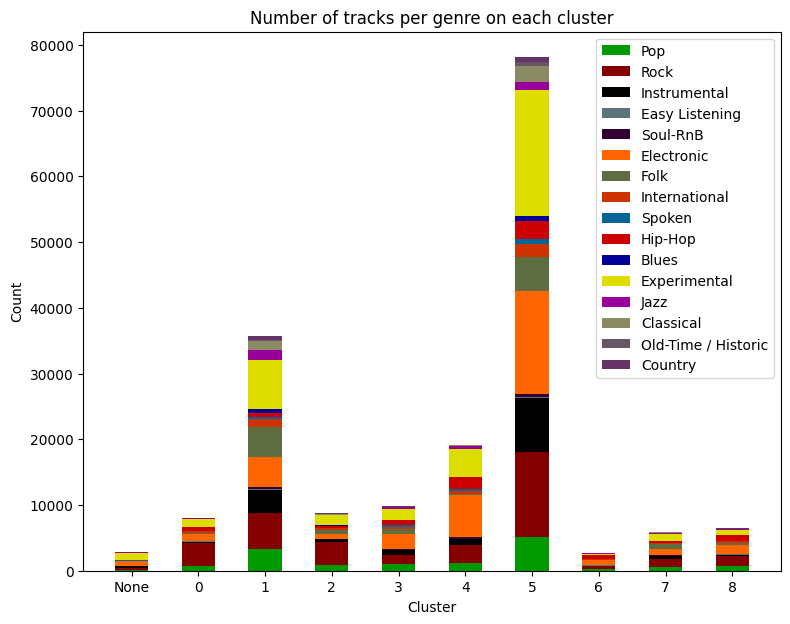

In [63]:
width = 0.5

fig, ax = plt.subplots(figsize=(9, 7))
bottom = np.zeros(n_clusters + 1) # include the outliers

cluster_ids_xs = [-1] + list(range(n_clusters))

for genre in genres:
    p = ax.bar(cluster_ids_xs, genre_counts[genre], width, label=genre, bottom=bottom, color=genres_colors[genre])
    bottom += genre_counts[genre]

ax.set_title("Number of tracks per genre on each cluster")
ax.legend(loc="upper right", fontsize=10)
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
ax.set_xticks(ticks=cluster_ids_xs, labels=map(str, cluster_ids))

float_to_fname = lambda f: str(f).replace('.', '-')
fig.savefig(f'./results/graphs/clustering_genre_c{n_clusters}_std{float_to_fname(cluster_distance_threshold_standard_deviations)}_mvt{float_to_fname(compression_set_merge_variance_threshold)}_eps{float_to_fname(dbscan_eps)}.png')